# Probabilistic Relational Model - IMbalanced Learning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from torch import nn
from torch.utils.data import Subset, ConcatDataset
import torchmetrics

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from torchvision import datasets, transforms
from tqdm.autonotebook import tqdm

In [2]:
import ssl # for ssl certificate for downloading ptm's
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
import pretrainedmodels as ptm
xception_m = ptm.__dict__['xception'](num_classes=1000, pretrained='imagenet')

Modelo

In [4]:
from torchvision.models import resnet50, resnext50_32x4d

mean_losses = []
mean_acc = []
mean_f1s = []

class ConvEnsemble(pl.LightningModule):
    def __init__(self,config):
        super().__init__()
        self.LR = config['lr']
        self.EPOCHS = config['epochs']
        self.n_classes = 2
        # metrics
        task = "multiclass" if self.n_classes > 2 else "binary"
        self.accuracy = torchmetrics.Accuracy(task=task, num_classes=self.n_classes)
        self.f1score = torchmetrics.F1Score(task=task, num_classes=self.n_classes)
        # model
        self.resnet = torch.nn.Sequential(*(list(resnet50(pretrained=True).children())[:-1]))
        for param in self.resnet.parameters():
            param.requires_grad = False
        xception_m = ptm.__dict__['xception'](num_classes=1000, pretrained='imagenet')
        self.xception = torch.nn.Sequential(*(list(xception_m.children())[:-1]))
        for param in self.xception.parameters():
            param.requires_grad = False
        self.xception_conv = nn.Conv2d(2048, 2048, kernel_size=(7, 7))
        self.conv = nn.Conv2d(4096, 1024, kernel_size=(1, 1), padding='same')
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(1024, self.n_classes)
        # loss
        self.loss = nn.CrossEntropyLoss().cuda()
        
    def forward(self, x):
        B, F, H, W = x.shape
        x_resnet = self.resnet(x)
        x_xception = self.xception(x)
        x_xception = self.xception_conv(x_xception)#convert to (10,2048,1,1)
        x = torch.cat((x_resnet, x_xception), 1)
        x = self.conv(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x
    
    def training_step(self, batch, batch_no):
        x, y = batch
        logits = self(x)
        
        y_onehot = F.one_hot(y, num_classes=self.n_classes).long()
        acc = self.accuracy(logits, y_onehot)
        f1s = self.f1score(logits, y_onehot)
        mean_acc.append(acc.item())
        mean_f1s.append(f1s.item())
        
        mean_loss = self.loss(logits, y)
        mean_losses.append(mean_loss)
        
        return mean_loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.LR)
        return {
            "optimizer": optimizer,
            "lr_scheduler": torch.optim.lr_scheduler.OneCycleLR(
                                optimizer ,max_lr=0.01,
                                steps_per_epoch=self.SPE,
                                epochs=self.EPOCHS)
        }

Construir subsets a partir de los indices de clase

## <span style="color:blue">Plant Village</span>

In [5]:
data_transforms = transforms.Compose([
    transforms.RandomSizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder('../data/PlantVillage/train', data_transforms)
print(len(train_dataset), train_dataset.class_to_idx)
val_dataset = datasets.ImageFolder('../data/PlantVillage/val', data_transforms)
print(len(val_dataset), val_dataset.class_to_idx)

1583 {'tomato_healthy': 0, 'tomato_infected': 1}
381 {'tomato_healthy': 0, 'tomato_infected': 1}


/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/torchvision/transforms/transforms.py:703: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  warnings.warn("The use of the transforms.RandomSizedCrop transform is deprecated, " +


In [6]:
class_0_idxs = torch.nonzero(torch.Tensor(train_dataset.targets)==0).flatten()
class_1_idxs = torch.nonzero(torch.Tensor(train_dataset.targets)==1).flatten()
# Provocar bias cogiendo un porcentaje de la clase 1 solamente (modificando el porcentaje hasta obtener b_deg deseado)
# class_1_idxs = class_1_idxs[torch.randperm(len(class_1_idxs))[:int(len(class_1_idxs)*.409)]]

c0_s, c1_s = len(class_0_idxs), len(class_1_idxs)
b_deg = c0_s / c1_s
print('Class 0:', len(class_0_idxs), '/ Class 1:', len(class_1_idxs), '/ BDeg: ', b_deg)

class_1_subset = Subset(train_dataset, class_1_idxs)

# Lista de DataSets que luego se envolveran en DataLoaders
train_subsets = []
for i in range(int(np.ceil(b_deg))):
    class_0_subset = Subset(train_dataset, class_0_idxs[i*c1_s : i*c1_s+c1_s])
    train_subsets.append(ConcatDataset([class_0_subset, class_1_subset]))

for p in train_subsets:
    print(len(p), len(p)-c1_s)

Class 0: 1296 / Class 1: 287 / BDeg:  4.515679442508711
574 287
574 287
574 287
574 287
435 148


In [ ]:
BATCH_SIZE=10

def get_prediction(x, model: pl.LightningModule):
    model.freeze() # prepares model for predicting
    probabilities = torch.softmax(model(x), dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    model.unfreeze()
    return predicted_class, probabilities

def train_tune(config):
    testloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

    try: model = ConvEnsemble.load_from_checkpoint("saves/checkpoint.ckpt")
    except: model = ConvEnsemble(config)

    for stage, train_subset in enumerate(train_subsets):
        print(f'------------stage nº {stage}----------------------')

        trainloader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
        model.SPE = len(trainloader)
        
        # Training
        trainer = pl.Trainer(max_epochs=config['epochs'], devices=1, accelerator="gpu", default_root_dir="saves/")

        trainer.fit(model, trainloader)

        # Testing
        true_y, pred_y = [], []
        for batch in tqdm(iter(testloader), total=len(testloader)):
            x, y = batch
            true_y.extend(y)
            preds, probs = get_prediction(x, model)
            pred_y.extend(preds.cpu())
    
    report = classification_report(true_y, pred_y, output_dict=True)
    return report

EPOCHS = [10, 25, 30]
LRS = [1e-3, 1e-4]

grid_search = pd.DataFrame(columns=['epochs','lr','f1-0','f1-1','acc'])

for epochs in EPOCHS:
    for lr in LRS:
        config = {'epochs': epochs, 'lr': lr, 'class_sizes': [1,1]}
        report = train_tune(config)
        grid_search = grid_search.append(
                        pd.Series(
                            [epochs,lr,report['0']['f1-score'],report['1']['f1-score'],report['accuracy']],
                            index=grid_search.columns), 
                        ignore_index=True)
        grid_search.to_csv('./grid_search/PlantVillage_PRM-IM.csv')
grid_search

/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  f"The flag `devices={devices}` will be ignored, "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


------------stage nº 0----------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | accuracy      | BinaryAccuracy   | 0     
1 | f1score       | BinaryF1Score    | 0     
2 | resnet        | Sequential       | 23.5 M
3 | xception      | Sequential       | 20.8 M
4 | xception_conv | Conv2d           | 205 M 
5 | conv          | Conv2d           | 4.2 M 
6 | flatten       | Flatten          | 0     
7 | dropout       | Dropout          | 0     
8 | fc            | Linear           | 2.0 K 
9 | loss          | CrossEntropyLoss | 0     
---------------------------------------------------
209 M     Trainable params
44.3 M    Non-trainable params
254 M     Total params
1,016.141 Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [ ]:
mean_losses = []
mean_acc = []
mean_f1s = []

config = {'epochs': 25, 'lr': 1e-3}
report = train_tune(config)
print(report)

------------stage nº 0----------------------


/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  f"The flag `devices={devices}` will be ignored, "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: saves/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | accuracy | BinaryAccurac

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


  0%|          | 0/1165 [00:00<?, ?it/s]

/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  f"The flag `devices={devices}` will be ignored, "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


------------stage nº 1----------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | accuracy | BinaryAccuracy   | 0     
1 | f1score  | BinaryF1Score    | 0     
2 | resnet   | Sequential       | 23.5 M
3 | resnext  | Sequential       | 23.0 M
4 | conv     | Conv2d           | 4.2 M 
5 | flatten  | Flatten          | 0     
6 | dropout  | Dropout          | 0     
7 | fc       | Linear           | 2.0 K 
8 | loss     | CrossEntropyLoss | 0     
----------------------------------------------
50.7 M    Trainable params
0         Non-trainable params
50.7 M    Total params
202.741   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

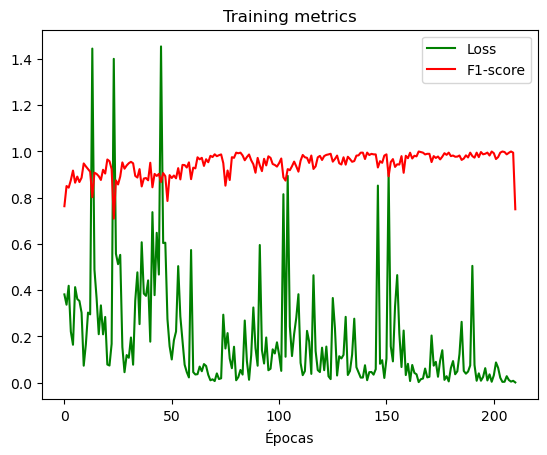

In [7]:
# Plot mean loss
splits = 49
ml = [sum(mean_losses[i:i + splits])/splits for i in range(0, len(mean_losses), splits)]
ma = [sum(mean_acc[i:i + splits])/splits for i in range(0, len(mean_acc), splits)]
mf = [sum(mean_f1s[i:i + splits])/splits for i in range(0, len(mean_f1s), splits)]
x_axis = [i for i in range(404)]

for i, l in enumerate(mean_losses):
    mean_losses[i] = l.cpu().detach()
plt.plot(x_axis, ml, 'g', label='Loss')
plt.plot(x_axis, ma, 'b', label='Accuracy')
plt.plot(x_axis, mf, 'r', label='F1-score')
plt.title('Training metrics')
plt.xlabel('Épocas')
# plt.ylabel('Loss media')
plt.legend()
plt.show()

In [ ]:
def get_prediction(x, model: pl.LightningModule):
    model.freeze() # prepares model for predicting
    probabilities = torch.softmax(model(x), dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    model.unfreeze()
    return predicted_class, probabilities

EPOCHS=15
BATCH_SIZE=10

testloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

try: model = ConvEnsemble.load_from_checkpoint("saves/checkpoint.ckpt")
except: model = ConvEnsemble()

# for stage, train_subset in enumerate(train_subsets):
stage = 0
print(f'------------stage nº {stage}----------------------')
train_subset = train_subsets[stage]
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

# Training
trainer = pl.Trainer(gpus=1, max_epochs=EPOCHS, devices=1, accelerator="gpu", default_root_dir="saves/")

trainer.fit(model, trainloader)

# Testing
true_y, pred_y = [], []
for batch in tqdm(iter(testloader), total=len(testloader)):
    x, y = batch
    true_y.extend(y)
    preds, probs = get_prediction(x, model)
    pred_y.extend(preds.cpu())

print(classification_report(true_y, pred_y, digits=3))

## <span style="color:blue">UTKFace</span>

In [ ]:
data_transforms = transforms.Compose([
    transforms.RandomSizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder('../data/UTKFace/train', data_transforms)
print(len(train_dataset), train_dataset.class_to_idx)
val_dataset = datasets.ImageFolder('../data/UTKFace/val', data_transforms)
print(len(val_dataset), val_dataset.class_to_idx)

In [ ]:
class_0_idxs = torch.nonzero(torch.Tensor(train_dataset.targets)==0).flatten()
class_1_idxs = torch.nonzero(torch.Tensor(train_dataset.targets)==1).flatten()
# Provocar bias cogiendo un porcentaje de la clase 1 solamente (modificando el porcentaje hasta obtener b_deg deseado)
class_1_idxs = class_1_idxs[torch.randperm(len(class_1_idxs))[:int(len(class_1_idxs)*.209)]]

c0_s, c1_s = len(class_0_idxs), len(class_1_idxs)
b_deg = c0_s / c1_s
print('Class 0:', len(class_0_idxs), '/ Class 1:', len(class_1_idxs), '/ BDeg: ', b_deg)

class_1_subset = Subset(train_dataset, class_1_idxs)

# Lista de DataSets que luego se envolveran en DataLoaders
train_subsets = []
for i in range(int(np.ceil(b_deg))):
    class_0_subset = Subset(train_dataset, class_0_idxs[i*c1_s : i*c1_s+c1_s])
    train_subsets.append(ConcatDataset([class_0_subset, class_1_subset]))

for p in train_subsets:
    print(len(p), len(p)-c1_s)

In [ ]:
BATCH_SIZE=10

def get_prediction(x, model: pl.LightningModule):
    model.freeze() # prepares model for predicting
    probabilities = torch.softmax(model(x), dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    model.unfreeze()
    return predicted_class, probabilities

def train_tune(config):
    testloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

    try: model = ConvEnsemble.load_from_checkpoint("saves/checkpoint.ckpt")
    except: model = ConvEnsemble(config)

    for stage, train_subset in enumerate(train_subsets):
        print(f'------------stage nº {stage}----------------------')

        trainloader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
        model.SPE = len(trainloader)
        
        # Training
        trainer = pl.Trainer(max_epochs=config['epochs'], devices=1, accelerator="gpu", default_root_dir="saves/")

        trainer.fit(model, trainloader)

        # Testing
        true_y, pred_y = [], []
        for batch in tqdm(iter(testloader), total=len(testloader)):
            x, y = batch
            true_y.extend(y)
            preds, probs = get_prediction(x, model)
            pred_y.extend(preds.cpu())
    
    report = classification_report(true_y, pred_y, output_dict=True)
    return report

EPOCHS = [10, 25, 30]
LRS = [1e-3, 1e-4]

grid_search = pd.DataFrame(columns=['epochs','lr','f1-0','f1-1','acc'])

for epochs in EPOCHS:
    for lr in LRS:
        config = {'epochs': epochs, 'lr': lr, 'class_sizes': [1,1]}
        report = train_tune(config)
        grid_search = grid_search.append(
                        pd.Series(
                            [epochs,lr,report['0']['f1-score'],report['1']['f1-score'],report['accuracy']],
                            index=grid_search.columns), 
                        ignore_index=True)
        grid_search.to_csv('./grid_search/PlantVillage_PRM-IM.csv')
grid_search

In [ ]:
mean_losses = []
mean_acc = []
mean_f1s = []

config = {'epochs': 25, 'lr': 1e-3}
report = train_tune(config)
print(report)

In [ ]:
# Plot mean loss
splits = 49
ml = [sum(mean_losses[i:i + splits])/splits for i in range(0, len(mean_losses), splits)]
ma = [sum(mean_acc[i:i + splits])/splits for i in range(0, len(mean_acc), splits)]
mf = [sum(mean_f1s[i:i + splits])/splits for i in range(0, len(mean_f1s), splits)]
x_axis = [i for i in range(404)]

for i, l in enumerate(mean_losses):
    mean_losses[i] = l.cpu().detach()
plt.plot(x_axis, ml, 'g', label='Loss')
plt.plot(x_axis, ma, 'b', label='Accuracy')
plt.plot(x_axis, mf, 'r', label='F1-score')
plt.title('Training metrics')
plt.xlabel('Épocas')
# plt.ylabel('Loss media')
plt.legend()
plt.show()